In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader, Subset
from PIL import Image
import numpy as np

# Local imports
from qml.models.multiclass import HybridQuantumMultiClassCNN, BatchedGPUHybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Dataset

In [4]:
df = pd.read_csv("data/bcn/bcn20000.csv")

In [5]:
from PIL import Image, ImageFile

# Scan for corrupted images
bad_images = []
for idx, row in df.iterrows():
    img_path = os.path.join("data/bcn/images", f"{row['isic_id']}.jpg")
    try:
        img = Image.open(img_path)
        img.load()  # Force full decode
    except Exception as e:
        bad_images.append((row['isic_id'], str(e)))

print(f"Found {len(bad_images)} corrupted images out of {len(df)}")
for name, err in bad_images:
    print(f"  {name}: {err}")

# Allow truncated images to be loaded during training
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 0 corrupted images out of 18944


In [6]:
cols_to_drop = [
    "attribution", # Same value for all rows
    "copyright_license", # Same value for all rows
    "anatom_site_special", # Too many NaN values
    "image_type", # Same value for all rows
    "diagnosis_confirm_type", # May introduce bias
    "lesion_id" # Not needed for training
]

# Drop columns that are not needed for training and null values
df_clean = df.drop(cols_to_drop, axis=1)
# Binary classification
df_clean = df_clean.where(df_clean["diagnosis_1"] != "Indeterminate")
df_clean = df_clean.where(df_clean["diagnosis_3"] != "Scar")
df_clean["diagnosis_3"] = df_clean["diagnosis_3"].replace({
    "Melanoma, NOS": "MEL",
    "Melanoma metastasis": "MEL",
    "Nevus": "NV",
    "Basal cell carcinoma": "BCC",
    "Squamous cell carcinoma, NOS": "SCC",
    "Dermatofibroma": "DF",
    "Solar lentigo": "BKL",
    "Seborrheic keratosis": "BKL",
    "Solar or actinic keratosis": "AK"
})
df_clean.dropna(inplace=True)

In [7]:
categorical_cols = [
    "anatom_site_general",
    "concomitant_biopsy",
    "diagnosis_1",
    "diagnosis_2",
    "diagnosis_3"
]

boolean_cols = [
    "melanocytic",
    "sex"
]

# For each categorical column, create a mapping
for col in boolean_cols:
    df_clean[col] = df_clean[col].map({'male': 1, 'female': 0, True: 1, False: 0}).astype(float)

# Mapping results for later use
cat_maps = {}

for col in categorical_cols:
    unique_vals = df_clean[col].unique()
    cat_map = {cat: idx for idx, cat in enumerate(unique_vals)}
    cat_maps[col] = cat_map
    df_clean[col] = df_clean[col].map(cat_map).astype(int)

df_clean.head()

,isic_id,age_approx,anatom_site_general,concomitant_biopsy,diagnosis_1,diagnosis_2,diagnosis_3,melanocytic,sex
0,ISIC_0053454,55.0,0,0,0,0,0,1.0,1.0
2,ISIC_0053456,50.0,0,0,0,0,0,1.0,0.0
3,ISIC_0053457,85.0,1,0,0,1,1,0.0,1.0
4,ISIC_0053458,35.0,1,0,1,2,2,1.0,1.0
5,ISIC_0053459,60.0,0,0,1,2,2,1.0,1.0


In [8]:
diagnosis_map = {v: k for k, v in cat_maps['diagnosis_1'].items()}
df_clean['diagnosis_1'].map(diagnosis_map).value_counts()

diagnosis_1
Malignant    8696
Benign       7208
Name: count, dtype: int64

In [9]:
class BcnDataset(Dataset):
    def __init__(self, data, image_folder, label_column):
        self.data = data
        self.image_folder = image_folder
        self.label_column = label_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = f"{row['isic_id']}.jpg"
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path)
        return image, row[self.label_column]
    
class TransformedDataset(Dataset):
    def __init__(self, base_subset, transform):
        self.base_subset = base_subset
        self.transform = transform

    def __len__(self):
        return len(self.base_subset)

    def __getitem__(self, idx):
        image, label = self.base_subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

class CircleCrop:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)

        # Convert to grayscale
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Threshold to separate black border from content
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return img  # No contours found, return original

        # Largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Make bounding box square
        side_len = max(w, h)
        cx, cy = x + w // 2, y + h // 2
        x_new = max(cx - side_len // 2, 0)
        y_new = max(cy - side_len // 2, 0)
        side_len = int(side_len)

        cropped_np = img_np[y_new:y_new+side_len, x_new:x_new+side_len]

        # Convert back to PIL Image
        cropped_img = Image.fromarray(cropped_np)

        return cropped_img


In [11]:
IMAGE_SIZE = 256

train_transform = transforms.Compose([
    CircleCrop(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    CircleCrop(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
# Configuration
LIMIT_SAMPLES = None # Set to an int (e.g., 2000) for quick experiments, None for full dataset
BATCH_SIZE = 64
TRAIN_SPLIT = 0.8

# Initialize Full Dataset
label_column = "diagnosis_1"
full_dataset = BcnDataset(
    data=df_clean,
    image_folder="data/bcn/images",
    label_column=label_column,
)

# Apply Limit if needed
if LIMIT_SAMPLES is not None:
    indices = np.random.choice(len(full_dataset), size=min(LIMIT_SAMPLES, len(full_dataset)), replace=False)
    dataset_to_split = Subset(full_dataset, indices.tolist())
else:
    # Use indices to shuffle even if full dataset
    indices = np.random.choice(len(full_dataset), size=len(full_dataset), replace=False)
    dataset_to_split = Subset(full_dataset, indices.tolist())

# Calculate sizes
total_size = len(dataset_to_split)
train_size = int(TRAIN_SPLIT * total_size)
test_size = total_size - train_size

# Split
train_subset, test_subset = random_split(dataset_to_split, [train_size, test_size])

# Apply Transforms
train_dataset = TransformedDataset(train_subset, train_transform)
test_dataset = TransformedDataset(test_subset, test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {len(cat_maps[label_column])}")

Total samples: 15904
Training samples: 12723
Test samples: 3181
Batch size: 64
Number of classes: 2


In [13]:
cat_maps

{'anatom_site_general': {'anterior torso': 0,
  'head/neck': 1,
  'upper extremity': 2,
  'lower extremity': 3,
  'palms/soles': 4,
  'oral/genital': 5},
 'concomitant_biopsy': {True: 0, False: 1},
 'diagnosis_1': {'Malignant': 0, 'Benign': 1},
 'diagnosis_2': {'Malignant melanocytic proliferations (Melanoma)': 0,
  'Malignant epidermal proliferations': 1,
  'Benign melanocytic proliferations': 2,
  'Benign epidermal proliferations': 3,
  'Malignant adnexal epithelial proliferations - Follicular': 4,
  'Benign soft tissue proliferations - Fibro-histiocytic': 5},
 'diagnosis_3': {'MEL': 0, 'SCC': 1, 'NV': 2, 'BKL': 3, 'BCC': 4, 'DF': 5}}

## Create Quantum CNN Model

In [14]:
from qml.models.binary import BatchedGPUHybridQuantumCNN

num_classes = len(cat_maps['diagnosis_1'])

print(f"Initializing model for {num_classes} classes.")

model = BatchedGPUHybridQuantumCNN(
    n_qubits=4,
    kernel_size=3,
    stride=2,
    input_size=IMAGE_SIZE, # Explicit input size
    pool_size=26,   # Explicit pool size to control linear layer size
    hidden_size=[64, 32]
)

model.to(device)

Initializing model for 2 classes.
Using lightning.qubit device with 'ry' encoding, StandardQCNNAnsatz, measurement=PauliZ
Using default.qubit device with 'ry' encoding, StandardQCNNAnsatz, measurement=PauliZ


BatchedGPUHybridQuantumCNN(
  (qconv): BatchedGPUQuantumConv2D()
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(26, 26))
  (classical): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=676, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Setup Training

In [15]:
from notebooks.utils import print_model_parameters
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                45,471
Trainable parameters:            45,471
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       43,264          Yes       
classical.1.bias                         64              Yes       
classical.4.weight                       2,048           Yes       
classical.4.bias                         32              Yes       
classical.7.weight                       32              Yes       
classical.7.bias                         1               Yes       


In [16]:
import torch.nn as nn
import torch.optim as optim
from notebooks.trainer import Trainer
import torch

LEARNING_RATE = 0.005
EPOCHS = 10

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# Calculate class imbalance for binary classification
class_counts = df_clean['diagnosis_1'].value_counts().sort_index().values
num_negative = class_counts[0]
num_positive = class_counts[1]

# pos_weight = num_negative / num_positive
pos_weight = torch.tensor([num_negative / num_positive], dtype=torch.float32).to(device)

print(f"Class Counts: Negative={num_negative}, Positive={num_positive}")
print(f"Positive Weight: {pos_weight.item():.4f}")

# Binary classification with weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

trainer = Trainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

Class Counts: Negative=8696, Positive=7208
Positive Weight: 1.2064


## Train Model

In [17]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader,
    scheduler=scheduler
)

Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 50/50 [07:59<00:00,  9.58s/it]


Epoch 1: Train Loss=0.7091, Train Acc=0.6317 | Test Loss=0.6621, Test Acc=0.6775


Evaluating: 100%|██████████| 50/50 [06:20<00:00,  7.62s/it]


Epoch 2: Train Loss=0.6717, Train Acc=0.6677 | Test Loss=0.6566, Test Acc=0.6863


Evaluating: 100%|██████████| 50/50 [06:18<00:00,  7.58s/it]


Epoch 3: Train Loss=0.6622, Train Acc=0.6811 | Test Loss=0.6512, Test Acc=0.6881


Evaluating: 100%|██████████| 50/50 [06:37<00:00,  7.95s/it]


Epoch 4: Train Loss=0.6549, Train Acc=0.6875 | Test Loss=0.6482, Test Acc=0.6929


Evaluating: 100%|██████████| 50/50 [06:41<00:00,  8.04s/it]


Epoch 5: Train Loss=0.6492, Train Acc=0.6944 | Test Loss=0.6631, Test Acc=0.6872


Evaluating: 100%|██████████| 50/50 [06:19<00:00,  7.59s/it]


Epoch 6: Train Loss=0.6414, Train Acc=0.6974 | Test Loss=0.6594, Test Acc=0.6929


Evaluating: 100%|██████████| 50/50 [06:18<00:00,  7.58s/it]


Epoch 7: Train Loss=0.6388, Train Acc=0.7026 | Test Loss=0.6440, Test Acc=0.6903


Evaluating: 100%|██████████| 50/50 [06:23<00:00,  7.67s/it]


Epoch 8: Train Loss=0.6337, Train Acc=0.7030 | Test Loss=0.6401, Test Acc=0.6982


Evaluating: 100%|██████████| 50/50 [07:24<00:00,  8.88s/it]


Epoch 9: Train Loss=0.6306, Train Acc=0.7079 | Test Loss=0.6312, Test Acc=0.7080


Evaluating: 100%|██████████| 50/50 [06:26<00:00,  7.74s/it]


Epoch 10: Train Loss=0.6062, Train Acc=0.7261 | Test Loss=0.6355, Test Acc=0.7067


## Train results

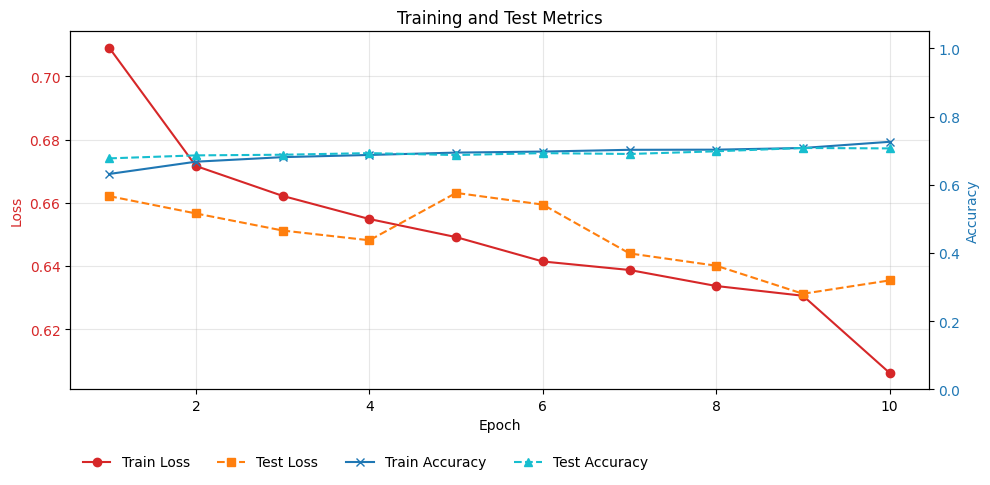

In [20]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Test Loss: 0.5649
Test Accuracy: 0.6763


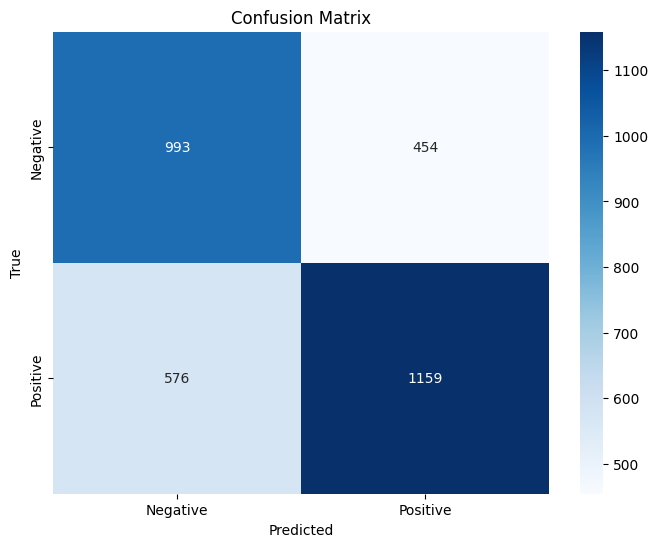


Detailed Metrics:
True Negatives:  993
False Positives: 454
False Negatives: 576
True Positives:  1159

Precision:  0.7185
Recall:     0.6680
F1 Score:   0.6924
Specificity: 0.6862


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = confusion_matrix.ravel()

print(f"\nDetailed Metrics:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nPrecision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"Specificity: {specificity:.4f}")